# 效能指標-預測最低價格-XGBOOST

**預測最低價格**

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# 讀取數據
file_path = "/Users/yuchingchen/Documents/專題/cleaned_data/short_flight_final.csv"
data = pd.read_csv(file_path)

# 分離經濟艙與非經濟艙的數據
economy_class_data = data[data["艙等"] == "經濟艙"].copy()
non_economy_class_data = data[data["艙等"] != "經濟艙"].copy()

# One-hot encoding
categorical_cols = ['星期', '出發時段', '出發機場代號', '抵達時段', '抵達機場代號',
                    '航空公司', '航空聯盟', '機型分類', '是否過夜', '是否為平日', '機型', '假期', 'Region']

economy_class_data = pd.get_dummies(economy_class_data, columns=categorical_cols, drop_first=True)
non_economy_class_data = pd.get_dummies(non_economy_class_data, columns=categorical_cols, drop_first=True)

# 確保兩個數據集擁有相同的特徵欄位
common_cols = list(set(economy_class_data.columns) & set(non_economy_class_data.columns))
economy_class_data = economy_class_data[common_cols]
non_economy_class_data = non_economy_class_data[common_cols]

# 標準化數值變數
num_cols = ['飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
scaler = StandardScaler()
economy_class_data[num_cols] = scaler.fit_transform(economy_class_data[num_cols])
non_economy_class_data[num_cols] = scaler.transform(non_economy_class_data[num_cols])

# 選取建模特徵
target_keywords = ['出發時段_', '出發機場代號_', '抵達時段_', '航空聯盟_', '機型分類_', '是否為平日_', '假期_', 'Region_']
economy_class_data_dummy_cols = [col for col in economy_class_data.columns if any(keyword in col for keyword in target_keywords)]
non_economy_class_data_dummy_cols = [col for col in non_economy_class_data.columns if any(keyword in col for keyword in target_keywords)]
economy_class_data_feature_cols = economy_class_data_dummy_cols + ['飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']
non_economy_class_data_feature_cols = non_economy_class_data_dummy_cols + ['飛行時間_分鐘', '經濟指標', '機場指標', 'competing_flights']

# 定義函數來訓練 XGBoost 模型並預測
def train_and_predict(X, y):
    # 切分資料
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # 訓練 XGBoost
    xgb_model = XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,  
        min_child_weight=5,  # 限制過小的葉子節點，減少過低的價格預測
        colsample_bytree=0.8, 
        subsample=0.8, 
        random_state=42, 
        n_jobs=-1
    )
    xgb_model.fit(X_train, y_train)
    
    # 預測測試集
    y_pred_test = xgb_model.predict(X_test)
    
    # 計算 MSE & R²
    mse = mean_squared_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)

    print(f"📌 測試集 MSE: {mse:.4f}")
    print(f"📌 測試集 R²: {r2:.4f}")

    # 預測整個數據集（包括訓練集與測試集）
    y_pred = xgb_model.predict(X)

    return y_pred

# **經濟艙** 預測最低價格
economy_class_data["預測最低價格_log"] = train_and_predict(economy_class_data[economy_class_data_feature_cols], 
                                                       economy_class_data["最低價格_log"])
# **非經濟艙** 預測最低價格
non_economy_class_data["預測最低價格_log"] = train_and_predict(non_economy_class_data[non_economy_class_data_feature_cols], 
                                                          non_economy_class_data["最低價格_log"])

# 轉換回原始價格
economy_class_data["預測最低價格"] = np.exp(economy_class_data["預測最低價格_log"])
non_economy_class_data["預測最低價格"] = np.exp(non_economy_class_data["預測最低價格_log"])

# 移除 log 欄位，只保留原始與預測價格
economy_class_data.drop(columns=["預測最低價格_log"], inplace=True)
non_economy_class_data.drop(columns=["預測最低價格_log"], inplace=True)

# 儲存預測結果
economy_class_data.to_csv('/Users/yuchingchen/Documents/專題/model/data/short_economy_minprice_predicted_xgb.csv', index=False)
non_economy_class_data.to_csv('/Users/yuchingchen/Documents/專題/model/data/short_non_economy_minprice_predicted_xgb.csv', index=False)

print("✅ 預測完成，已儲存為 CSV！")

📌 測試集 MSE: 0.0350
📌 測試集 R²: 0.8891
📌 測試集 MSE: 0.0187
📌 測試集 R²: 0.7776
✅ 預測完成，已儲存為 CSV！


**計算效能指標**

In [21]:
import pandas as pd

# 讀取預測結果
economy_file = "/Users/yuchingchen/Documents/專題/model/data/short_economy_minprice_predicted_xgb.csv"
non_economy_file = "/Users/yuchingchen/Documents/專題/model/data/short_non_economy_minprice_predicted_xgb.csv"

economy_class_data = pd.read_csv(economy_file)
non_economy_class_data = pd.read_csv(non_economy_file)

def recover_airport_code(df):
    """ 找回原始的 出發機場代號, 抵達機場代號 """
    
    # 找出所有出發機場和抵達機場的 One-Hot Encoding 欄位
    departure_cols = [col for col in df.columns if col.startswith("出發機場代號_")]
    arrival_cols = [col for col in df.columns if col.startswith("抵達機場代號_")]
    departure_time_cols = [col for col in df.columns if col.startswith("出發時段_")]

    # 還原出發機場代號
    if departure_cols:
        df["出發機場代號"] = df[departure_cols].idxmax(axis=1).str.replace("出發機場代號_", "", regex=True)
    
    # 還原抵達機場代號
    if arrival_cols:
        df["抵達機場代號"] = df[arrival_cols].idxmax(axis=1).str.replace("抵達機場代號_", "", regex=True)

    # 還原出發時段
    if departure_time_cols:
        df["出發時段"] = df[departure_time_cols].idxmax(axis=1).str.replace("出發時段_", "", regex=True)
    return df

economy_class_data = recover_airport_code(economy_class_data)
non_economy_class_data = recover_airport_code(non_economy_class_data)

# 計算效能
economy_class_data["效能"] = (economy_class_data["隨機購買平均價格"] - economy_class_data["預測最低價格"]) / economy_class_data["隨機購買平均價格"]
non_economy_class_data["效能"] = (non_economy_class_data["隨機購買平均價格"] - non_economy_class_data["預測最低價格"]) / non_economy_class_data["隨機購買平均價格"]

# 計算最佳效能
economy_class_data["最佳效能"] = (economy_class_data["隨機購買平均價格"] - economy_class_data["最低價格"]) / economy_class_data["隨機購買平均價格"]
non_economy_class_data["最佳效能"] = (non_economy_class_data["隨機購買平均價格"] - non_economy_class_data["最低價格"]) / non_economy_class_data["隨機購買平均價格"]


# 計算標準化效能
economy_class_data["標準化效能"] = economy_class_data["效能"] / economy_class_data["最佳效能"]
non_economy_class_data["標準化效能"] = non_economy_class_data["效能"] / non_economy_class_data["最佳效能"]

# 保留特定欄位
selected_cols = ["出發時間", "出發時段", "出發機場代號", "抵達機場代號", "航班代碼", "隨機購買平均價格", "預測最低價格", "最低價格", "效能", "最佳效能", "標準化效能"]
economy_class_data = economy_class_data[selected_cols]
non_economy_class_data = non_economy_class_data[selected_cols]

# 儲存結果
economy_output_file = "/Users/yuchingchen/Documents/專題/model/data/short_economy_minprice_performance_xgb.csv"
non_economy_output_file = "/Users/yuchingchen/Documents/專題/model/data/short_non_economy_minprice_performance_xgb.csv"

economy_class_data.to_csv(economy_output_file, index=False)
non_economy_class_data.to_csv(non_economy_output_file, index=False)

print("✅ 效能計算完成，結果已儲存")

✅ 效能計算完成，結果已儲存


**平均節省比例**

In [22]:
# 讀取預測結果
economy_file = "/Users/yuchingchen/Documents/專題/model/data/short_economy_minprice_performance_xgb.csv"
non_economy_file = "/Users/yuchingchen/Documents/專題/model/data/short_non_economy_minprice_performance_xgb.csv"

economy_class_data = pd.read_csv(economy_file)
non_economy_class_data = pd.read_csv(non_economy_file)

# 過濾掉最佳效能 = 0 的航班
economy_class_data = economy_class_data[economy_class_data["最佳效能"] != 0]
non_economy_class_data = non_economy_class_data[non_economy_class_data["最佳效能"] != 0]

# 計算經濟艙的效能
average_savings_economy = economy_class_data["效能"].mean() * 100
best_possible_savings_economy = economy_class_data["最佳效能"].mean() * 100

# 計算非經濟艙的效能
average_savings_non_economy = non_economy_class_data["效能"].mean() * 100
best_possible_savings_non_economy = non_economy_class_data["最佳效能"].mean() * 100

# 按出發機場 & 抵達機場計算平均節省比例
savings_by_route = economy_class_data.groupby(["出發機場代號", "抵達機場代號"])["效能"].mean() * 100

# 按出發時段來看節省比例
savings_by_time = economy_class_data.groupby("出發時段")["效能"].mean() * 100

# 統計標準化效能的分佈
efficiency_summary = economy_class_data["標準化效能"].describe()

# 計算大於 1 的比例（表示預測價格低於市場最低價）
efficiency_above_1 = (economy_class_data["標準化效能"] > 1).mean() * 100

# 計算接近 1（±0.05） 的比例（表示模型預測接近市場最低價）
efficiency_near_1 = ((economy_class_data["標準化效能"] >= 0.95) & (economy_class_data["標準化效能"] <= 1.05)).mean() * 100

# 計算小於 1 的比例（表示模型還沒完全學到市場最低價）
efficiency_below_1 = (economy_class_data["標準化效能"] < 1).mean() * 100

# 印出結果
print(f"📉 經濟艙平均節省比例: {average_savings_economy:.2f}%")
print(f"📉 非經濟艙平均節省比例: {average_savings_non_economy:.2f}%")
print(f"🎯 經濟艙最佳節省比例: {best_possible_savings_economy:.2f}%")
print(f"🎯 非經濟艙最佳節省比例: {best_possible_savings_non_economy:.2f}%")

# 印出節省最多與最少的航線
print("💰 節省最多的航線：")
print(savings_by_route.nlargest(5))
print("\n💸 節省最少的航線：")
print(savings_by_route.nsmallest(5))

# 印出不同出發時段的節省比例
print("\n🕒 出發時段的節省比例：")
print(savings_by_time)

# 印出標準化效能的統計
print("\n📊 標準化效能的統計：")
print(efficiency_summary)
print(f"\n📈 標準化效能 > 1 的比例：{efficiency_above_1:.2f}%")
print(f"📈 0.95 <= 標準化效能 <= 1.05 的比例：{efficiency_near_1:.2f}%")
print(f"📈 標準化效能 < 1 的比例：{efficiency_below_1:.2f}%")

📉 經濟艙平均節省比例: 18.75%
📉 非經濟艙平均節省比例: 8.45%
🎯 經濟艙最佳節省比例: 19.46%
🎯 非經濟艙最佳節省比例: 8.81%
💰 節省最多的航線：
出發機場代號  抵達機場代號
TSA     ICN       27.195780
        GMP       21.618082
        NRT       21.426927
        HND       18.817145
        SIN       17.800708
Name: 效能, dtype: float64

💸 節省最少的航線：
出發機場代號  抵達機場代號
TSA     HKG       13.681267
        SIN       17.800708
        HND       18.817145
        NRT       21.426927
        GMP       21.618082
Name: 效能, dtype: float64

🕒 出發時段的節省比例：
出發時段
下午班機    19.575952
凌晨班機    24.049832
早晨班機    17.686543
晚間班機    17.790544
Name: 效能, dtype: float64

📊 標準化效能的統計：
count    6626.000000
mean        2.413809
std        51.920202
min      -201.954571
25%         0.632957
50%         0.942179
75%         1.230936
max      3513.124000
Name: 標準化效能, dtype: float64

📈 標準化效能 > 1 的比例：42.74%
📈 0.95 <= 標準化效能 <= 1.05 的比例：11.17%
📈 標準化效能 < 1 的比例：57.26%


**檢查預測價格的分布**

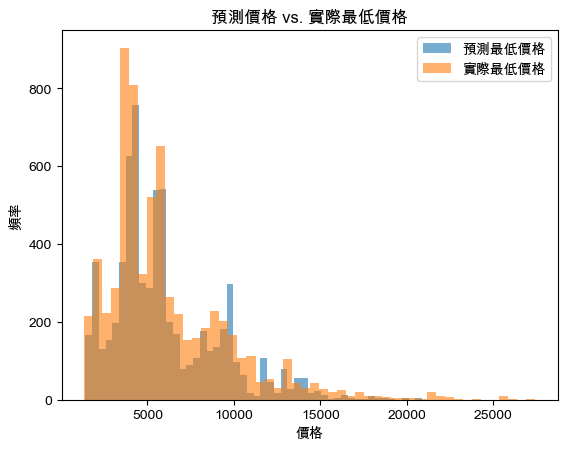

In [23]:
import matplotlib.pyplot as plt

# 繁體中文設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 讀取預測結果
economy_file = "/Users/yuchingchen/Documents/專題/model/data/short_economy_minprice_performance_xgb.csv"
non_economy_file = "/Users/yuchingchen/Documents/專題/model/data/short_non_economy_minprice_performance_xgb.csv"

economy_class_data = pd.read_csv(economy_file)
non_economy_class_data = pd.read_csv(non_economy_file)

# 過濾掉最佳效能 = 0 的航班
economy_class_data = economy_class_data[economy_class_data["最佳效能"] != 0]
non_economy_class_data = non_economy_class_data[non_economy_class_data["最佳效能"] != 0]

plt.hist(economy_class_data["預測最低價格"], bins=50, alpha=0.6, label="預測最低價格")
plt.hist(economy_class_data["最低價格"], bins=50, alpha=0.6, label="實際最低價格")
plt.legend()
plt.xlabel("價格")
plt.ylabel("頻率")
plt.title("預測價格 vs. 實際最低價格")
plt.show()